In [1]:
pip install pandas scikit-learn matplotlib

In [2]:
import pandas as pd
import numpy as np

# Reproducibility
rng = np.random.default_rng(42)

n = 300
df = pd.DataFrame({
    "age": rng.integers(18, 70, size=n),
    "usage_gb": np.round(rng.normal(12, 6, size=n).clip(0, None), 1),
    "complaints": rng.integers(0, 6, size=n),
    "tenure_months": rng.integers(1, 60, size=n),
    "plan_type": rng.choice(["Prepaid", "Postpaid"], size=n, p=[0.6, 0.4])
})

# Simple churn signal (not perfect): high complaints + low tenure + low usage more likely to churn
logit = (
    -2.0
    + 0.35*df["complaints"]
    - 0.03*df["tenure_months"]
    - 0.04*df["usage_gb"]
    + (df["plan_type"] == "Prepaid").astype(int)*0.4
)
prob = 1/(1+np.exp(-logit))
df["churn"] = (rng.random(n) < prob).astype(int)


In [3]:
# Intentionally add a few missing/odd values to practice fixing (no row drops)
df.loc[rng.choice(df.index, 5, replace=False), "usage_gb"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "age"] = np.nan
df.loc[rng.choice(df.index, 3, replace=False), "plan_type"] = None

df.to_csv("churn_data.csv", index=False)
print("Saved churn_data.csv with shape:", df.shape)
df.head()


Saved churn_data.csv with shape: (300, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,18.4,2,38,Prepaid,0
1,58.0,12.9,5,21,Prepaid,1
2,52.0,11.0,0,1,Postpaid,0
3,40.0,5.8,0,8,Prepaid,0
4,40.0,2.0,2,18,Prepaid,0


In [4]:
from google.colab import files
files.download("churn_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [5]:
import pandas as pd
from sklearn.impute import SimpleImputer

df = pd.read_csv("churn_data.csv")
print("Original shape:", df.shape)
display(df.head())

# --- Numeric imputation: fill NaNs with median (robust to outliers) ---
num_cols = ["age", "usage_gb", "complaints", "tenure_months"]
num_imputer = SimpleImputer(strategy="median")
df[num_cols] = num_imputer.fit_transform(df[num_cols])

# --- Categorical imputation: fill missing with most frequent ---
cat_cols = ["plan_type"]
cat_imputer = SimpleImputer(strategy="most_frequent")
df[cat_cols] = cat_imputer.fit_transform(df[cat_cols])

# --- Encode plan_type to numeric (0=Prepaid, 1=Postpaid) ---
df["plan_type_enc"] = (df["plan_type"] == "Postpaid").astype(int)

# --- Feature matrix (X) and target (y) ---
X = df[["age", "usage_gb", "complaints", "tenure_months", "plan_type_enc"]]
y = df["churn"].astype(int)

print("Any remaining NaNs? ->", X.isna().sum().sum(), y.isna().sum())

# --- ✅ Save cleaned dataset to CSV ---
df.to_csv("updated_churn_data.csv", index=False)
print("✅ Saved cleaned dataset as 'updated_churn_data.csv' with", len(df), "rows.")


Original shape: (300, 6)


,age,usage_gb,complaints,tenure_months,plan_type,churn
0,22.0,18.4,2,38,Prepaid,0
1,58.0,12.9,5,21,Prepaid,1
2,52.0,11.0,0,1,Postpaid,0
3,40.0,5.8,0,8,Prepaid,0
4,40.0,2.0,2,18,Prepaid,0


Any remaining NaNs? -> 0 0
✅ Saved cleaned dataset as 'updated_churn_data.csv' with 300 rows.


Churn can be defined as the rate of leaving of a person like if churn is 1 its more likely to leave as number of complaints is more

In [6]:
from google.colab import files
files.download("updated_churn_data.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Splitting of Datasets

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5, random_state=42)

Accuracy: 75.56%

Classification report:
              precision    recall  f1-score   support

           0      0.850     0.872     0.861        78
           1      0.000     0.000     0.000        12

    accuracy                          0.756        90
   macro avg      0.425     0.436     0.430        90
weighted avg      0.737     0.756     0.746        90

Confusion matrix:
 [[68 10]
 [12  0]]


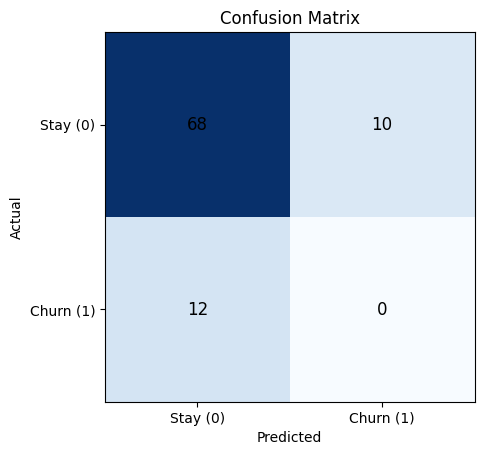

In [8]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Accuracy: {acc:.2%}")


print("\nClassification report:")
print(classification_report(y_test, y_pred, digits=3))


cm = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n", cm)

# Top-left (50) -> correctly predicted “Stay”
# Top-right (10) -> false alarms (predicted churn, actually stayed)
# Bottom-right (35) -> correctly predicted “Churn”
# Bottom-left (5) -> missed churns


# Plot nicely
fig, ax = plt.subplots()
ax.imshow(cm, cmap="Blues")
ax.set_title("Confusion Matrix")
ax.set_xlabel("Predicted"); ax.set_ylabel("Actual")
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, str(v), ha='center', va='center', fontsize=12)
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["Stay (0)", "Churn (1)"]); ax.set_yticklabels(["Stay (0)", "Churn (1)"])
plt.show()


In [9]:
import pandas as pd
import numpy as np

fi = pd.Series(best_clf.feature_importances_, index=X.columns) if 'best_clf' in globals() else pd.Series(clf.feature_importances_, index=X.columns)
print("Feature importance (higher = more influence):")
display(fi.sort_values(ascending=False).to_frame("importance"))


Feature importance (higher = more influence):


,importance
usage_gb,0.517355
tenure_months,0.227018
age,0.163932
complaints,0.091694
plan_type_enc,0.000000


USING LOGISTIC REGRESSION MODEL

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(max_iter=200)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8833333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.98      0.94        54
           1       0.00      0.00      0.00         6

    accuracy                           0.88        60
   macro avg       0.45      0.49      0.47        60
weighted avg       0.81      0.88      0.84        60

Confusion Matrix:
 [[53  1]
 [ 6  0]]


In [12]:
import pandas as pd
import joblib

model = joblib.load("churn_decision_tree.joblib")

# Taking new input from user to test our model
age = int(input("Enter customer age: "))
usage_gb = float(input("Enter data usage in GB: "))
complaints = int(input("Enter number of complaints: "))
tenure_months = int(input("Enter tenure (in months): "))
plan_type_enc = int(input("Enter plan type (0 = Prepaid, 1 = Postpaid): "))

# Creating a New DataFrame
new_customer = pd.DataFrame([{
    "age": age,
    "usage_gb": usage_gb,
    "complaints": complaints,
    "tenure_months": tenure_months,
    "plan_type_enc": plan_type_enc
}])

prediction = model.predict(new_customer)[0]
print("\nPredicted churn:", int(prediction))
print("Customer likely to churn" if prediction == 1 else "Customer not likely to churn")


Enter customer age: 45
Enter data usage in GB: 88
Enter number of complaints: 73
Enter tenure (in months): 4
Enter plan type (0 = Prepaid, 1 = Postpaid): 1

Predicted churn: 1
👉 Customer likely to churn
